# Problem: Linear Regression

Given `f(3) = 7`, `f(4) = 9`, `f(5) = 11` predict `f(x) = 2x + 1` in general.

There can be multiple inputs as well such as when given `g(1, 2) = -4`, `g(2, 1) = 1` predict `g(x, y) = 2x - 3y`.

### Let's start by importing our beloved libraries for computation

In [1]:
import hnumpy as hnp
import numpy as np

### And some helpers for visualization

In [2]:
import matplotlib.pyplot as plt
from IPython.display import display

### We need a dataset
It is a handcrafted one for simplicity but any dataset would work.

In [3]:
x = np.array([[130], [110], [100], [145], [160], [185], [200], [80], [50]])
y = np.array([325, 295, 268, 400, 420, 500, 520, 220, 120])

### Let's visualize our dataset to get a grasp of it

In [4]:
plt.ioff()
fig, ax = plt.subplots(1)

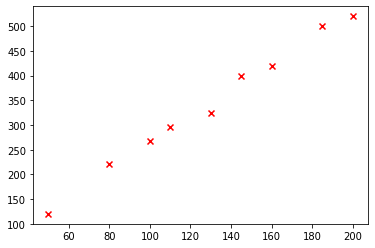

In [5]:
ax.scatter(x[:, 0], y, marker="x", color="red")
display(fig)

### Now, we need a model
The main purpose of this tutorial is not to train a linear regression model but to use it homomorphically. So we will not discuss about how the model is trained.

In [6]:
class Model:
    θ = None
    c = None

    def fit(self, x, y):
        A = np.ones((x.shape[0], x.shape[1] + 1), dtype=np.float32)
        A[:, 1:] = x

        regularization_contribution = np.identity(x.shape[1] + 1, dtype=np.float32)
        regularization_contribution[0][0] = 0

        parameters = np.linalg.pinv(A.T @ A + regularization_contribution) @ A.T @ y

        self.c = parameters[0]
        self.θ = parameters[1:].reshape(-1, 1)

        return self

    def evaluate(self, x):
        return x @ self.θ + self.c

    def compile(self, bounds, shape):
        return hnp.compile_fhe(
            self.evaluate,
            {"x": hnp.encrypted_ndarray(bounds=bounds, shape=shape)},
            config=hnp.config.CompilationConfig(parameter_optimizer="handselected"),
        )

### Let's create our model

In [7]:
model = Model().fit(x, y)

### And make some predictions

In [8]:
inputs = np.linspace(40, 210, 100).reshape(-1, 1)
predictions = model.evaluate(inputs)

### Let's visualize our predictions to see whether our model works

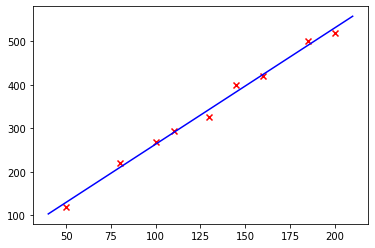

In [9]:
ax.plot(inputs, predictions, color="blue")
display(fig)

### Nice! But can we evaluate it homomorphically? Well, of course we can! Let's compile it.

In [10]:
homomorphic_model = model.compile(bounds=(35, 215), shape=inputs.shape)

2021-06-30 14:47:06.131 | INFO     | hnumpy.convert:compile_fhe:380 - Compiling evaluate into an FHE function
2021-06-30 14:47:06.132 | INFO     | hnumpy.convert:compile_fhe:382 - Checking input and output
2021-06-30 14:47:06.133 | INFO     | hnumpy.convert:compile_homomorphic:265 - Create target graph
2021-06-30 14:47:06.134 | INFO     | hnumpy.convert:compile_homomorphic:270 - Optimize target graph with optimizer `handselected`
2021-06-30 14:47:06.139 | INFO     | hnumpy.convert:compile_homomorphic:286 - Correct encoding
2021-06-30 14:47:06.139 | INFO     | hnumpy.convert:compile_homomorphic:289 - Create VM graph
2021-06-30 14:47:06.140 | INFO     | hnumpy.convert:compile_homomorphic:305 - Return the result to the caller


### And create encryption keys

In [11]:
context = homomorphic_model.create_context()
keys = context.keygen()

2021-06-30 14:47:06.143 | INFO     | hnumpy.client:keygen:29 - Creating 0 keyswitching key(s) and 1 bootstrapping key(s). This should take approximately 30 seconds (0.5 minutes)
2021-06-30 14:48:47.502 | DEBUG    | hnumpy.client:keygen:42 - Key creation time took 101.35792642099841 seconds


### Finally, the moment of truth

In [12]:
homomorphic_predictions = homomorphic_model.encrypt_and_run(keys, inputs)

### And it's visualization

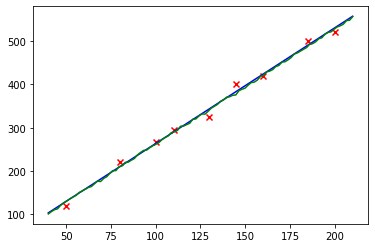

In [13]:
ax.plot(inputs, homomorphic_predictions, color="green")
display(fig)

# Beautiful! And as a bonus, here is the multivariate version!

In [14]:
x = np.array([[6, 6], [12, 8], [16, 11], [4, 0], [5, 2], [1, 1], [8, 6], [11, 15], [7, 12]])
y = np.array([10, 19, 24, 3, 6, 2, 14, 22, 16.5])

In [15]:
fig = plt.figure(2)
ax = fig.add_subplot(1, 1, 1, projection="3d")

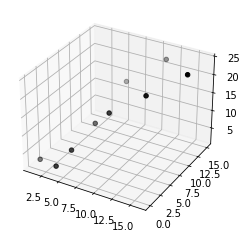

In [16]:
ax.scatter(x[:, 0], x[:, 1], y, marker="o", color="black")
display(fig)

In [17]:
model = Model().fit(x, y)

In [18]:
grid_x, grid_y = np.meshgrid(np.linspace(0, 16, 25), np.linspace(0, 16, 25))

inputs = np.zeros((25 * 25, 2))
inputs[:, 0] = grid_x.reshape((25 * 25, ))
inputs[:, 1] = grid_y.reshape((25 * 25, ))

predictions = model.evaluate(inputs)

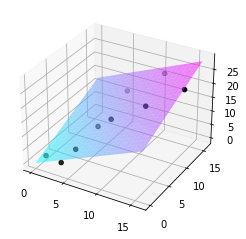

In [19]:
ax.plot_surface(
    grid_x,
    grid_y,
    predictions.reshape(grid_x.shape),
    alpha=0.5,
    antialiased=True,
    rstride=1,
    cstride=1,
    cmap="cool",
)
display(fig)

In [20]:
homomorphic_model = model.compile(bounds=(-1, 17), shape=inputs.shape)

2021-06-30 14:49:01.018 | INFO     | hnumpy.convert:compile_fhe:380 - Compiling evaluate into an FHE function
2021-06-30 14:49:01.019 | INFO     | hnumpy.convert:compile_fhe:382 - Checking input and output
2021-06-30 14:49:01.020 | INFO     | hnumpy.convert:compile_homomorphic:265 - Create target graph
2021-06-30 14:49:01.021 | INFO     | hnumpy.convert:compile_homomorphic:270 - Optimize target graph with optimizer `handselected`
2021-06-30 14:49:01.030 | INFO     | hnumpy.convert:compile_homomorphic:286 - Correct encoding
2021-06-30 14:49:01.032 | INFO     | hnumpy.convert:compile_homomorphic:289 - Create VM graph
2021-06-30 14:49:01.033 | INFO     | hnumpy.convert:compile_homomorphic:305 - Return the result to the caller


In [21]:
context = homomorphic_model.create_context()
keys = context.keygen()

2021-06-30 14:49:01.039 | INFO     | hnumpy.client:keygen:29 - Creating 0 keyswitching key(s) and 1 bootstrapping key(s). This should take approximately 30 seconds (0.5 minutes)
2021-06-30 14:50:40.143 | DEBUG    | hnumpy.client:keygen:42 - Key creation time took 99.10206578399993 seconds


In [22]:
homomorphic_predictions = homomorphic_model.encrypt_and_run(keys, inputs)

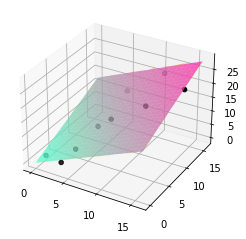

In [23]:
ax.plot_surface(
    grid_x,
    grid_y,
    homomorphic_predictions.reshape(grid_x.shape),
    alpha=0.5,
    antialiased=True,
    rstride=1,
    cstride=1,
    cmap="Wistia",
)
display(fig)

# Stunning!